In [1]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread

### Heat PINN

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation

In [41]:
def visualize_points(x_test, y_test, u_test, norm, title="PINN"):
    # Create a directory to save the images
    save_path="images"
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axis
    plt.scatter(x_test, y_test, c=u_test, marker='o', cmap='viridis', norm=norm)
    plt.title(title)
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')

    # Save the plot to the images directory
    num = str(len(os.listdir(save_path)))
    plt.savefig(os.path.join(save_path, f'{title}_{num}.png'))

    # Show the plot
    # plt.show()

In [34]:
def set_boundary_conditions(edge_temps, square_size, num_points_per_edge, T):
    x_boundary_top = np.linspace(0, square_size, num_points_per_edge)
    y_boundary_top = np.ones_like(x_boundary_top) * square_size

    x_boundary_right = np.ones(num_points_per_edge) * square_size
    y_internal_right = np.linspace(0, square_size, num_points_per_edge)

    x_boundary_bottom = np.linspace(square_size, 0, num_points_per_edge)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros(num_points_per_edge)
    y_boundary_left = np.linspace(square_size, 0, num_points_per_edge)

    x_boundary = np.concatenate([x_boundary_top, x_boundary_right, x_boundary_bottom, x_boundary_left])
    y_boundary = np.concatenate([y_boundary_top, y_internal_right, y_boundary_bottom, y_boundary_left])

    u_boundary = np.zeros_like(x_boundary)

    u_boundary[:num_points_per_edge] = np.linspace(edge_temps[0], edge_temps[1], num_points_per_edge) # edge_temps[0]  # Top edge
    u_boundary[num_points_per_edge:2*num_points_per_edge] = np.linspace(edge_temps[2], edge_temps[1], num_points_per_edge) # edge_temps[1]  # Right edge
    u_boundary[2*num_points_per_edge:3*num_points_per_edge] = np.linspace(edge_temps[2], edge_temps[3], num_points_per_edge) # edge_temps[2]  # Bottom edge
    u_boundary[3*num_points_per_edge:] = np.linspace(edge_temps[0], edge_temps[3], num_points_per_edge) # edge_temps[3]  # Left edge
    
    t_boundary = np.linspace(0, T, len(x_boundary))

    class BoundaryConditions:
        def __init__(self, x, y, t, u):
            self.x = x
            self.y = y
            self.t = t
            self.u = u

    boundary_conditions = BoundaryConditions(x_boundary, y_boundary, t_boundary, u_boundary)

    return boundary_conditions

In [21]:
def set_initial_conditions(initial_distribution_func, square_size, num_points, random=False):
    # Randomly generate points or make a mesh
    if random:
        x_initial = np.random.uniform(0, square_size, num_points)
        y_initial = np.random.uniform(0, square_size, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_initial = x_grid.flatten()
        y_initial = y_grid.flatten()
    
    t_initial = np.zeros_like(x_initial)
    
    u_initial = initial_distribution_func(x_initial, y_initial)

    class Conditions:
        def __init__(self, x, y, t, u):
            self.x = x
            self.y = y
            self.t = t
            self.u = u

    initial_conditions = Conditions(x_initial, y_initial, t_initial, u_initial)
    
    return initial_conditions

def constant_initial_distribution(x, y):
    return np.ones_like(x) * 2

In [22]:
def set_equation(square_size, num_points, T, random=False):
    if random:
        x_equation = np.random.uniform(0, square_size, num_points)
        y_equation = np.random.uniform(0, square_size, num_points)
        t_equation = np.random.uniform(0, T, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_equation = x_grid.flatten()
        y_equation = y_grid.flatten()
        
        t_equation = np.linspace(0, T, len(x_equation))

    class Equation:
        def __init__(self, x, y, t):
            self.x = x
            self.y = y
            self.t = t

    equation = Equation(x_equation, y_equation, t_equation)

    return equation

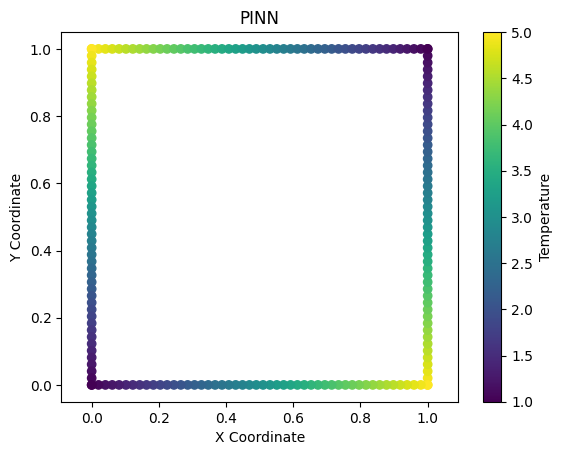

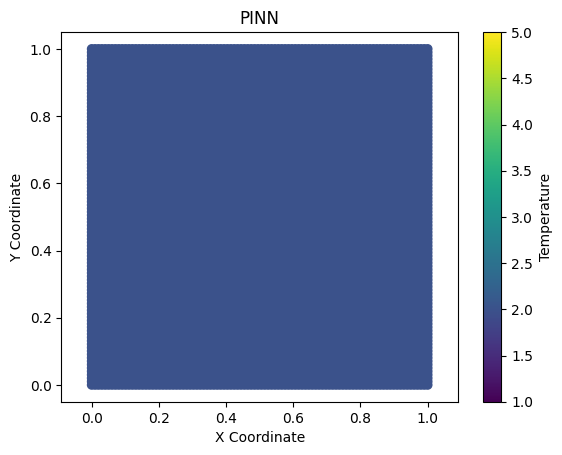

In [35]:
# Set temperatures at the edges [top, right, bottom, left]
edge_temperatures = [5, 1, 5, 1]

# Size of calculation area
square_size = 1.0

# Time of simulation
T = 0.1

# Number of points per edge
num_points_per_edge = 50

# Generate boundary conditions
boundary_conditions = set_boundary_conditions(edge_temperatures, 
                                              square_size, 
                                              num_points_per_edge, 
                                              T)

# Number of points in calculation area
num_points_initial = 100

# Generate initial conditions
initial_conditions = set_initial_conditions(constant_initial_distribution, 
                                            square_size, 
                                            num_points_initial, 
                                            random=False)

# Number of points in equation
num_points_equation = 100

# Generate equation
equation = set_equation(square_size, num_points_equation, T, random=False)

temperature_min = min(np.min(boundary_conditions.u), np.min(initial_conditions.u))
temperature_max = max(np.max(boundary_conditions.u), np.max(initial_conditions.u))
norm = Normalize(vmin=temperature_min, vmax=temperature_max)

visualize_points(boundary_conditions.x, boundary_conditions.y, boundary_conditions.u, norm)
visualize_points(initial_conditions.x, initial_conditions.y, initial_conditions.u, norm)

In [46]:
class PINN():
    def __init__(self, initial_conditions, boundary_conditions, equation):
        # Set data
        self.x_initial = torch.tensor(initial_conditions.x[:, np.newaxis],
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.y_initial = torch.tensor(initial_conditions.y[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.t_initial = torch.tensor(initial_conditions.t[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.u_initial = torch.tensor(initial_conditions.u[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        
        self.x_boundary = torch.tensor(boundary_conditions.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.y_boundary = torch.tensor(boundary_conditions.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.t_boundary = torch.tensor(boundary_conditions.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.u_boundary = torch.tensor(boundary_conditions.u[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        
        self.x_equation = torch.tensor(equation.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)
        self.y_equation = torch.tensor(equation.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)
        self.t_equation = torch.tensor(equation.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)

        # Coefficient of termal conductivity
        self.alpha = 0.1

        # Null vector is needed in equation loss
        self.null = torch.zeros((self.x_equation.shape[0], 1))

        # Initialize network:
        self.network()

        # Optimizer
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), 
        #                                    lr=1, 
        #                                    max_iter=5000, 
        #                                    max_eval=50000,
        #                                    history_size=50, 
        #                                    tolerance_grad=1e-010, 
        #                                    tolerance_change=0.5 * np.finfo(float).eps,
        #                                    line_search_fn="strong_wolfe")

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        
        # From: https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/blob/main/PyTorch/Burgers'%20Equation/Burgers.ipynb
        # optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
        #                       max_iter = 250, 
        #                       max_eval = None, 
        #                       tolerance_grad = 1e-05, 
        #                       tolerance_change = 1e-09, 
        #                       history_size = 100, 
        #                       line_search_fn = 'strong_wolfe')

        # Loss function
        self.mse = nn.MSELoss()

        # Loss
        self.loss = 0

        # Iteration number
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.Tanh(),
            nn.Linear(60, 60), nn.Tanh(),
            nn.Linear(60, 1))

    def function(self, x, y, t, is_equation=False):
        u_pred = self.net(torch.hstack((x, y, t)))

        if is_equation:
            dudx = torch.autograd.grad(u_pred, x, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udx2 = torch.autograd.grad(dudx, x, 
                                         grad_outputs=torch.ones_like(dudx), 
                                         create_graph=True)[0]
            dudy = torch.autograd.grad(u_pred, y, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udy2 = torch.autograd.grad(dudy, y, 
                                         grad_outputs=torch.ones_like(dudy), 
                                         create_graph=True)[0]
            dudt = torch.autograd.grad(u_pred, t, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            return u_pred, dudt, d2udx2, d2udy2

        return u_pred

    def closure(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # Initial loss
        u_prediction = self.function(self.x_initial, self.y_initial, self.t_initial)
        initial_loss = self.mse(u_prediction, self.u_initial)

        # Boundary loss
        u_prediction = self.function(self.x_boundary, self.y_boundary, self.t_boundary)
        boundary_loss = self.mse(u_prediction, self.u_boundary)

        # Equation loss
        _, dudt, d2udx2, d2udy2 = self.function(self.x_equation, self.y_equation, self.t_equation, is_equation=True)
        heat_eq_prediction = dudt - pow(self.alpha, 2) * (d2udx2 + d2udy2)
        equation_loss = self.mse(heat_eq_prediction, self.null)

        self.loss = initial_loss + boundary_loss + equation_loss

        # Derivative with respect to weights
        self.loss.backward()

        self.iter += 1
        if not self.iter % 100:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.loss))

        return self.loss

    def train(self):
        # Training loop
        for _ in range(10000):
            self.net.train()
            self.optimizer.step(self.closure)

In [47]:
# Create model
pinn = PINN(initial_conditions, boundary_conditions, equation)

# Train model
pinn.train()

# Save model
torch.save(pinn.net.state_dict(), 'model.pt')

Iteration: 100, Loss: 1.861053
Iteration: 200, Loss: 1.734703
Iteration: 300, Loss: 1.383468
Iteration: 400, Loss: 0.795034
Iteration: 500, Loss: 0.641248
Iteration: 600, Loss: 0.595240
Iteration: 700, Loss: 0.538103
Iteration: 800, Loss: 0.489927
Iteration: 900, Loss: 0.457375
Iteration: 1000, Loss: 0.430522
Iteration: 1100, Loss: 0.407953
Iteration: 1200, Loss: 0.385586
Iteration: 1300, Loss: 0.362752
Iteration: 1400, Loss: 0.339333
Iteration: 1500, Loss: 0.315253
Iteration: 1600, Loss: 0.294477
Iteration: 1700, Loss: 0.280287
Iteration: 1800, Loss: 0.268155
Iteration: 1900, Loss: 0.261189
Iteration: 2000, Loss: 0.244310
Iteration: 2100, Loss: 0.232475
Iteration: 2200, Loss: 0.220133
Iteration: 2300, Loss: 0.208725
Iteration: 2400, Loss: 0.198314
Iteration: 2500, Loss: 0.190801
Iteration: 2600, Loss: 0.181122
Iteration: 2700, Loss: 0.173798
Iteration: 2800, Loss: 0.167458
Iteration: 2900, Loss: 0.161668
Iteration: 3000, Loss: 0.156310
Iteration: 3100, Loss: 0.151510
Iteration: 3200, 

In [48]:
def set_test(square_size, num_points, time, random=False):
    if random:
        x_test = np.random.uniform(0, square_size, num_points)
        y_test = np.random.uniform(0, square_size, num_points)
        t_test = np.ones(num_points) * time
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_test = x_grid.flatten()
        y_test = y_grid.flatten()

        t_test = np.ones(len(x_test)) * 0.1    

    class Test:
        def __init__(self, x, y, t):
            self.x = x
            self.y = y
            self.t = t

    test = Test(x_test, y_test, t_test)

    return test

In [ ]:
pinn = PINN(initial_conditions, boundary_conditions, equation)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

for time in np.linspace(0, 0.1, 100):
    test = set_test(1, 100, time)
    x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
    y_test = torch.tensor(test.y[:, np.newaxis], dtype=torch.float32, requires_grad=True)
    t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)
    u = pinn.function(x_test, y_test, t_test)
    visualize_points(test.x, test.y, u.to('cpu').detach().numpy(), norm)

In [99]:
from PIL import Image

folder_path = 'images'

image_files = sorted(
    [img for img in os.listdir(folder_path) if img.endswith(".png")],
    key=lambda x: int(x.split('_')[1].split('.')[0]),
)

images = [Image.open(os.path.join(folder_path, img)) for img in image_files]

images[0].save('output.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)
print("GIF image has been created and saved as 'output.gif'")

GIF image has been created and saved as 'output.gif'


torch.Size([10000, 1])


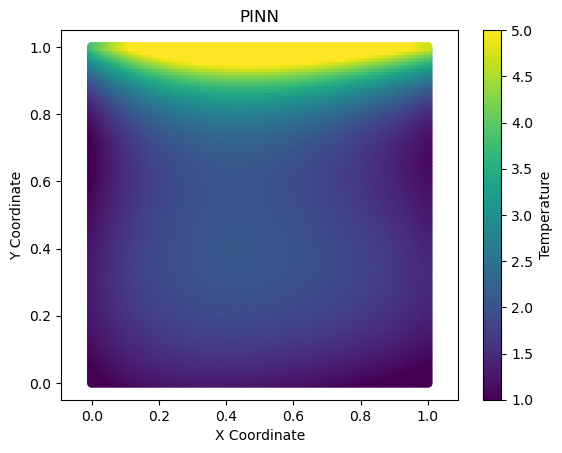

In [16]:
print(u.shape)

visualize_points(test.x, test.y, u.to('cpu').detach().numpy(), norm)

### FDM solver

In [70]:
def set_initial_conditions(initial_temperature, u):
    u[:, :, 0] = initial_temperature
    return u

def set_boundary_conditions(edge_temperatures, u):
    num_points_x, num_points_y, num_points_t = u.shape
    
    # Top edge
    u[num_points_x-1, :, :] = np.tile(np.linspace(edge_temperatures[0], edge_temperatures[1], num_points_x), (num_points_t, 1)).T # edge_temperatures[0]

    # Right edge
    u[:, num_points_y-1, :] = np.tile(np.linspace(edge_temperatures[2], edge_temperatures[1], num_points_y), (num_points_t, 1)).T # edge_temperatures[1]

    # Bottom edge
    u[:, 0, :] = np.tile(np.linspace(edge_temperatures[3], edge_temperatures[2], num_points_x), (num_points_t, 1)).T # edge_temperatures[2]

    # Left edge
    u[0, :, :] = np.tile(np.linspace(edge_temperatures[3], edge_temperatures[0], num_points_y), (num_points_t, 1)).T # edge_temperatures[3]

    return u

In [75]:
# Coefficient of termal conductivity
alpha = 0.5

# Size of calculation area
square_size = 1.0

# Number of points per edge
num_points = 100

dt = 0.001 # time step
T = 0.1 # final time

# Set temperatures at the edges [top, right, bottom, left] and initial temperature
edge_temperatures = [5, 1, 5, 1]
initial_temperature = 2

# Size of calculation area
square_size = 1.0

# Computes cell length
dx = square_size/num_points
dy = square_size/num_points

# Courant number
CFL = 0.1
dt = CFL * pow(dx, 2) / alpha

u = np.zeros((num_points,num_points,int(T/dt)))
print("Size of calculation area", u.shape)

u = set_initial_conditions(initial_temperature, u)
u = set_boundary_conditions(edge_temperatures, u)

# Generate 2D mesh
X = np.linspace(0, square_size, num_points, endpoint=True)
Y = np.linspace(0, square_size, num_points, endpoint=True)
X, Y = np.meshgrid(X, Y)

# Main time-loop of explicit method
for t in range(int(T/dt)-1):
    for i in range(1, num_points-1):
        for j in range(1, num_points-1):
            # Computing the right-hand side
            a = (u[i+1, j, t] - 2*u[i, j, t] + u[i-1, j, t]) / pow(dx, 2)  # d2dx2
            b = (u[i, j+1, t] - 2*u[i, j, t] + u[i, j-1, t]) / pow(dy, 2)  # d2dy2
            u[i, j, t+1] = pow(alpha, 2) * dt * (a + b) + u[i, j, t]

Size of calculation area (100, 100, 5000)


In [84]:
def visualize_temperature(u, time_index, norm, title="FDM"):
    # Create a directory to save the images
    save_path="images"

    # Create a figure and axis
    # os.makedirs(save_path, exist_ok=True)

    plt.imshow(u[:, :, time_index], cmap='viridis', origin='lower',
               extent=[0, 1, 0, 1], norm=norm)
    
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')

    # Save the plot to the images directory
    num = len(os.listdir(save_path))
    plt.savefig(os.path.join(save_path, f'{title}_{num}.png'))
    plt.close()

    # Show the plot
    # plt.show()

In [139]:
temperature_min = np.min(u)
temperature_max = np.max(u)
print(temperature_min, temperature_max)

1.0 5.0


In [98]:
temperature_min = np.min(u)
temperature_max = np.max(u)
norm=Normalize(vmin=temperature_min, vmax=temperature_max)

t_index = 3000

for time_index in range(0, u.shape[2], 100):
    visualize_temperature(u, time_index, norm, title="FDM")

### Compare methods

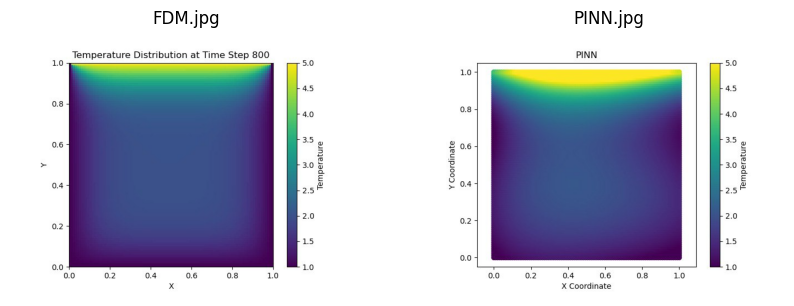

In [5]:
images_folder = "images"
image_files = os.listdir(images_folder)
image_files = [f for f in image_files if ((f.endswith(".png") or f.endswith(".jpg")) and 
                                          (f.startswith("PINN") or f.startswith("FDM")))]

if len(image_files) == 2:
    image1 = imread(os.path.join(images_folder, image_files[0]))
    image2 = imread(os.path.join(images_folder, image_files[1]))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].set_title(image_files[0])
    axes[0].axis("off")

    axes[1].imshow(image2)
    axes[1].set_title(image_files[1])
    axes[1].axis("off")

    plt.show()